# Market Analysis

**Loading all libraries**

In [53]:
# libraries for utility
import pandas as pd
import numpy as np
import math
import datetime
import json

# libraries for display and plotting
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# libraries for data providers
import yfinance as yf
import requests
import asyncio
import websockets

# libraries for statistics
from scipy.stats import pearsonr 
from sklearn.linear_model import LinearRegression

In [54]:
def running_mean(arr):
    running_mean = []
    for idx, num in enumerate(arr):
        running_mean.append((np.sum(arr[0:idx])+num)/(idx+1))
    return running_mean

**1.2 Yahoo Finance - Data download**

In [55]:
from_date = '2020-08-11'

In [56]:
yahoo_bit = yf.download('BTC-USD', from_date)

[*********************100%***********************]  1 of 1 completed


In [57]:
yahoo_serum = yf.download('SRM-USD', from_date)

[*********************100%***********************]  1 of 1 completed


In [58]:
yahoo_eth = yf.download('ETH-USD', from_date)

[*********************100%***********************]  1 of 1 completed


In [59]:
yahoo_snp = yf.download('^GSPC', from_date)

[*********************100%***********************]  1 of 1 completed


In [60]:
exchange_rate_USD_GBP = yf.download('GBP=X', from_date)

[*********************100%***********************]  1 of 1 completed


Conclusion: Different prices against the different providers.

**2. Seasonality**

**Calculating Correlation**

In [61]:
def calc_perc_diff(a: list):
    return [(x - a[i - 1])/a[i-1] for i, x in enumerate(a) if i > 0]

Generate percentages series.

In [62]:
bit_perc = calc_perc_diff(yahoo_bit['Open'])

In [63]:
serum_perc = calc_perc_diff(yahoo_serum['Open'])

In [64]:
snp_perc = calc_perc_diff(yahoo_snp['Open'])

In [65]:
eth_perc = calc_perc_diff(yahoo_eth['Open'])

Bitcoin-Serum

In [66]:
print('Bitcoin correlation with Serum: ', np.corrcoef(bit_perc[-len(serum_perc):],serum_perc)[0][1])

Bitcoin correlation with Serum:  0.06178993330049724


Bitcoin-S&P

In [67]:
print('Bitcoin correlation with SNP: ', np.corrcoef(bit_perc[-len(snp_perc):],snp_perc)[0][1])

Bitcoin correlation with SNP:  0.02413639951366378


Serum-S&P

In [68]:
print('Serum correlation with SNP: ', np.corrcoef(serum_perc[-len(snp_perc):],snp_perc)[0][1])

Serum correlation with SNP:  0.030378235353013698


Bitcoin-Ethereum

In [69]:
print('Bitcoin correlation with Ethereum: ', np.corrcoef(bit_perc,eth_perc)[0][1])

Bitcoin correlation with Ethereum:  0.8045918179831688


Time frames of the correlation:

1 year

In [70]:
print('Bitcoin correlation with Ethereum for 1 year window: ', np.corrcoef(bit_perc[-365:],eth_perc[-365:])[0][1])

Bitcoin correlation with Ethereum for 1 year window:  0.8829961974613466


5 years

In [71]:
print('Bitcoin correlation with Ethereum for 1 year window: ', np.corrcoef(bit_perc[-365*5:],eth_perc[-365*5:])[0][1])

Bitcoin correlation with Ethereum for 1 year window:  0.8045918179831688


Text(0.5, 1.0, 'Bitcoin percentage returns')

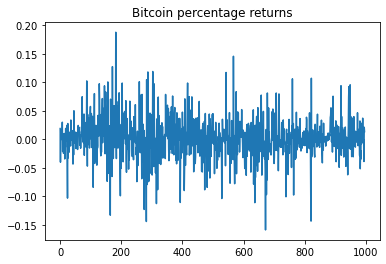

In [72]:
plt.plot(bit_perc)
plt.title('Bitcoin percentage returns')

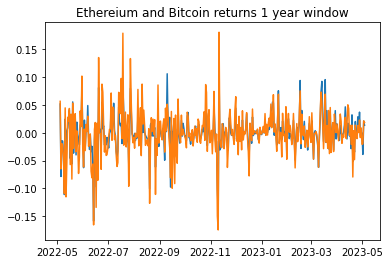

In [73]:
fig, ax = plt.subplots()

x=yahoo_bit['Open'].index[-365:]
ax.plot_date(x,bit_perc[-365:],'-','b')
ax.plot_date(x,eth_perc[-365:],'-','g')

plt.title('Ethereium and Bitcoin returns 1 year window')
plt.show()

Weekly trends

In [74]:
def weekly_trend(data_series):
    monday=data_series[data_series.index.weekday == 0]['Open'].mean()
    tuesday=data_series[data_series.index.weekday == 1]['Open'].mean()
    wednesday=data_series[data_series.index.weekday == 2]['Open'].mean()
    thursday=data_series[data_series.index.weekday == 3]['Open'].mean()
    friday=data_series[data_series.index.weekday == 4]['Open'].mean()
    saturday=data_series[data_series.index.weekday == 5]['Open'].mean()
    sunday=data_series[data_series.index.weekday == 6]['Open'].mean()

    series = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]
    total_average = sum(series)/len(series)

    data = [[monday/total_average,tuesday/total_average, wednesday/total_average, thursday/total_average, friday/total_average, saturday/total_average, sunday/total_average]]
    
    return pd.DataFrame(data, columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], index =["Trend"])


def print_results(df):
    display(df)
    max_n = 0
    col_max = "Monday"
    min_n = 1000
    col_min = "Monday"
    
    for col in df.columns:
        if(df[col][0]>max_n):
            max_n=df[col][0]
            col_max = col
        if(df[col][0]<min_n):
            min_n=df[col][0]
            col_min = col
        
        
    print("Best day to buy: ", col_min)
    print("Best day to sell: ",col_max)
    return


Bitcoin

In [75]:
df = weekly_trend(yahoo_bit)
print_results(df)
max_n = df.max(axis=1)
min_n = df.min(axis=1)
perc = (max_n-min_n)/max_n
print()
print("Percentage change won with this strategy: ","{:.1%}".format(float(perc)))
print("Percentage change daily high/low: ","{:.1%}".format(float(((yahoo_bit["High"] - yahoo_bit["Low"])/yahoo_bit["High"]).mean())))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,0.998389,0.998823,0.998837,1.00181,1.00008,1.00033,1.001731


Best day to buy:  Monday
Best day to sell:  Thursday

Percentage change won with this strategy:  0.3%
Percentage change daily high/low:  4.7%


Ethereum

In [34]:
print_results(weekly_trend(yahoo_eth))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,0.997401,0.998071,0.999857,1.004537,1.002167,0.997497,1.00047


Best day to buy:  Monday
Best day to sell:  Thursday


Serum

In [35]:
print_results(weekly_trend(yahoo_serum))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,1.012077,1.000906,0.996459,0.998702,0.99672,0.996002,0.999133


Best day to buy:  Saturday
Best day to sell:  Monday


1 Year window

In [36]:
print_results(weekly_trend(yahoo_bit[-365:]))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,1.000435,0.99539,0.996404,1.007009,1.002166,0.999251,0.999345


Best day to buy:  Tuesday
Best day to sell:  Thursday


In [37]:
print_results(weekly_trend(yahoo_eth[-365:]))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,0.999234,0.995342,0.994256,1.007412,1.003304,1.000175,1.000277


Best day to buy:  Wednesday
Best day to sell:  Thursday


In [38]:
print_results(weekly_trend(yahoo_serum[-365:]))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Trend,1.006486,0.993583,0.983911,1.000848,1.005639,0.997475,1.012059


Best day to buy:  Wednesday
Best day to sell:  Sunday
